# 결측치 조치 및 pipeline 구성

## 1.환경준비 

### (1) 라이브러리, 함수 불러오기 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### (2) 데이터 불러오기

In [2]:
data = pd.read_csv('https://bit.ly/3FsgwkJ')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* test set 분리하기

In [4]:
data0, test = train_test_split(data, test_size = 20, random_state = 20)
data0.shape, test.shape

((871, 12), (20, 12))

In [5]:
test

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
347,348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S
791,792,0,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S
836,837,0,3,"Pasic, Mr. Jakob",male,21.0,0,0,315097,8.6625,NaN,S
56,57,1,2,"Rugg, Miss. Emily",female,21.0,0,0,C.A. 31026,10.5000,NaN,S
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S
762,763,1,3,"Barah, Mr. Hanna Assi",male,20.0,0,0,2663,7.2292,NaN,C
561,562,0,3,"Sivic, Mr. Husein",male,40.0,0,0,349251,7.8958,NaN,S
383,384,1,1,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",female,35.0,1,0,113789,52.0000,NaN,S
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S


## 2.데이터 전처리

### (1) 불필요한 데이터 처리
* 불필요한 정보를 제외시킵시다.
    * Unique value (식별자) 는 모델링에서 제외시킵니다.

In [6]:
drop_cols = ['PassengerId','Ticket','Name']
data1 = data0.drop(drop_cols, axis = 1)
data1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
58,1,2,female,5.0,1,2,27.7500,NaN,S
619,0,2,male,26.0,0,0,10.5000,NaN,S
472,1,2,female,33.0,1,2,27.7500,NaN,S
521,0,3,male,22.0,0,0,7.8958,NaN,S
438,0,1,male,64.0,1,4,263.0000,C23 C25 C27,S


### (2) NaN 조치1

**1) 결측치 조회하기**
* 결측치를 조회해 봅시다.
* 어떻게 해결하는게 좋을까요? 해결 방법에 따라 적용 시점이 달라집니다.

In [7]:
temp1 = pd.DataFrame(data1.isna().sum())
temp2 = pd.DataFrame(data1.isna().sum()/data1.shape[0])
temp3 = pd.concat([temp1, temp2], axis =1 )
temp3.columns = ['NaN 건수', 'NaN 비율']
temp3

,NaN 건수,NaN 비율
Survived,0,0.000000
Pclass,0,0.000000
Sex,0,0.000000
Age,174,0.199770
SibSp,0,0.000000
Parch,0,0.000000
Fare,0,0.000000
Cabin,671,0.770379
Embarked,2,0.002296


* 시각화

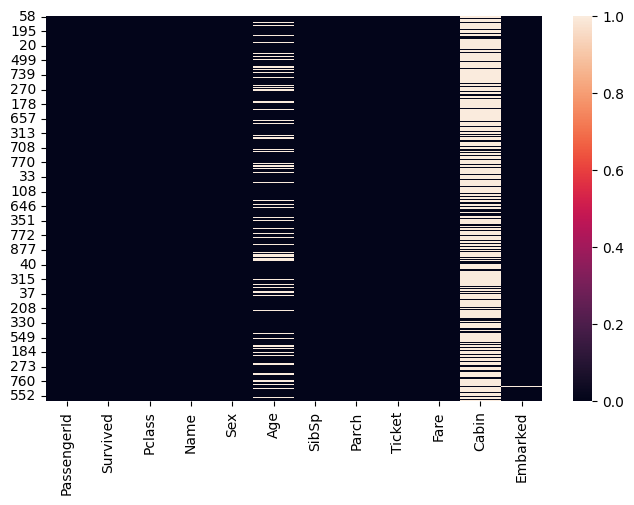

In [8]:
plt.figure(figsize = (8,5))
sns.heatmap(data0.isna())
plt.show()

* 어떻게 조치하는게 좋을까요?
    * 삭제 
        * 행 : 이 시점에 수행(필수)
        * 열 : 이 시점에 수행(권장), 가변수화 전까지 수행
    * 채우기
        * 단일값 : 범주 - 가변수화 전까지 수행, 숫자 - 스케일링 전까지
        * 추정값 : 스케일링 이후

* 어떻게 조치 방법에 따라 처리 시점이 달라집니다.
    * Embarked는 최빈값으로 **지금** 채우고
    * Age는 KNNImputer로 **가변수화 후에** 채우겠습니다.

* NaN 행 삭제를 결정한다면...
    * 운영에서 NaN이 들어오면 그 역시 버리겠다는 의미 입니다. 
        * 그래도 괜찮다면...
        * 그러나 괜찮은 상황은 별로 없을 겁니다.

**2) 삭제**

In [9]:
# 열 삭제(이후에는 불필요한 데이터 처리와 함께 코드를 수행합니다.)
drop_cols = ['Cabin']
data1 = data1.drop(drop_cols, axis = 1)
data1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
58,1,2,female,5.0,1,2,27.7500,S
619,0,2,male,26.0,0,0,10.5000,S
472,1,2,female,33.0,1,2,27.7500,S
521,0,3,male,22.0,0,0,7.8958,S
438,0,1,male,64.0,1,4,263.0000,S


**3) 채우기 : 단일값**

* SimpleImputer 

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [10]:
# 범주형 변수 : 최빈값으로 채우기
simpute_cols = ['Embarked']

# imputer 선언
s_imputer = SimpleImputer(strategy = 'most_frequent')

# fitting 및 적용
data1[simpute_cols] = s_imputer.fit_transform(data1[simpute_cols])
data1.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         174
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

**4) 실습**
* data1을 temp로 복사한 후에 temp['Age'] 에 대해서 평균으로 채워 봅시다.

In [11]:
temp = data1.copy()

In [12]:
simpute_cols = ['Age']

# imputer 선언
temp_imputer = SimpleImputer(strategy = 'mean')

# fitting 및 적용
temp[simpute_cols] = temp_imputer.fit_transform(temp[simpute_cols])
temp.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### (3) Feature Engineering
* family 변수를 추가하려고 합니다. 가족과 관련된 변수가 SibSp, Parch 입니다. 이 둘을 더하고 자기(1)까지 포함시켜서 가족 수 변수를 만듭시다.
* 그리고, SibSp, Parch 는 제거합니다.

In [13]:
data1['Family'] = data1['SibSp'] + data1['Parch'] + 1
data1.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
data1.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
58,1,2,female,5.0,27.7500,S,4
619,0,2,male,26.0,10.5000,S,1
472,1,2,female,33.0,27.7500,S,4
521,0,3,male,22.0,7.8958,S,1
438,0,1,male,64.0,263.0000,S,6


### (4) 가변수화

In [14]:
cat = {'Sex':["female", "male"]
       , 'Embarked':["C", "Q", "S"]
       ,'Pclass':[1,2,3]}

for k, v in cat.items():
    data1[k] = pd.Categorical(data1[k], categories=v, ordered=False)

data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 871 entries, 58 to 355
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  871 non-null    int64   
 1   Pclass    871 non-null    category
 2   Sex       871 non-null    category
 3   Age       697 non-null    float64 
 4   Fare      871 non-null    float64 
 5   Embarked  871 non-null    category
 6   Family    871 non-null    int64   
dtypes: category(3), float64(2), int64(2)
memory usage: 37.0 KB


In [15]:
data1 = pd.get_dummies(data1, columns =cat.keys(), drop_first = True)

### (5) 데이터 분할

* x, y 분할

In [16]:
target = 'Survived'
x = data1.drop(target, axis = 1)
y = data1.loc[:, target]

* train, val 분할

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state = 20)

### (6) 스케일링

* 스케일링이 분포를 변환시키는 것은 아닙니다.
    * MinMaxScaler
    * StandardScaler
* 스케일링에 따라 성능에 차이가 조금 날 수는 있지만, 성능을 향상시키는 일반적인 방법은 아닙니다.
* 스케일링을 데이터프레임 전체에 적용하고 나면 결과는 np.array로 나옵니다.
    * 그대로 모델링할 수도 있고, 다시 데이터프레임으로 변환해도 좋습니다.

* scaler 생성 및 train에 적용

In [18]:
x_cols = list(x_train)
x_cols

['Age',
 'Fare',
 'Family',
 'Sex_male',
 'Embarked_Q',
 'Embarked_S',
 'Pclass_2',
 'Pclass_3']

In [19]:
# 선언
scaler = MinMaxScaler()

# fitting & 적용
x_train_s = scaler.fit_transform(x_train)

# (옵션) 데이터프레임 변환
x_train_s = pd.DataFrame(x_train_s, columns = x_cols)

* val에 적용

In [20]:
# validation 적용
x_val_s = scaler.transform(x_val)

# (옵션) 데이터프레임 변환
x_val_s = pd.DataFrame(x_val_s, columns = x_cols)

### (7) NaN 조치2

* KNNImputer
https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

In [21]:
from sklearn.impute import KNNImputer

In [22]:
# 선언하기
k_imputer = KNNImputer()

# fitting & 적용하기
x_train_s = k_imputer.fit_transform(x_train_s)
x_train_s = pd.DataFrame(x_train_s, columns = x_cols)

In [23]:
x_train_s.isna().sum()

Age           0
Fare          0
Family        0
Sex_male      0
Embarked_Q    0
Embarked_S    0
Pclass_2      0
Pclass_3      0
dtype: int64

* validation set에 적용하기

In [24]:
# validation 적용
x_val_s = k_imputer.transform(x_val_s)
x_val_s = pd.DataFrame(x_val_s, columns = x_cols)

In [25]:
x_val_s.isna().sum()

Age           0
Fare          0
Family        0
Sex_male      0
Embarked_Q    0
Embarked_S    0
Pclass_2      0
Pclass_3      0
dtype: int64

-----------------

## 3.모델링

### (1) 모델생성

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *

In [27]:
model = DecisionTreeClassifier(max_depth = 5)
model.fit(x_train_s, y_train)

DecisionTreeClassifier(max_depth=5)

### (2) 검증

In [28]:
pred = model.predict(x_val_s)

In [29]:
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[145   7]
 [ 44  66]]
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       152
           1       0.90      0.60      0.72       110

    accuracy                           0.81       262
   macro avg       0.84      0.78      0.79       262
weighted avg       0.82      0.81      0.80       262



## 4.실습 : Data Pipeline 정리
* 모델이 운영환경에 배포되었다고 가정합니다.
* 이제 pipeline을 구성해 봅시다.
* 운영에서 new data가 주어졌을 때, 어떤 절차로 파이프라인을 구성해야 할까요?

In [30]:
# new data : test
test

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
347,348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S
791,792,0,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S
836,837,0,3,"Pasic, Mr. Jakob",male,21.0,0,0,315097,8.6625,NaN,S
56,57,1,2,"Rugg, Miss. Emily",female,21.0,0,0,C.A. 31026,10.5000,NaN,S
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S
762,763,1,3,"Barah, Mr. Hanna Assi",male,20.0,0,0,2663,7.2292,NaN,C
561,562,0,3,"Sivic, Mr. Husein",male,40.0,0,0,349251,7.8958,NaN,S
383,384,1,1,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",female,35.0,1,0,113789,52.0000,NaN,S
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S


### (1) 전처리 코드 정리
* 전처리 단계에서 수행한 코드들을 아래 하나의 셀에 다 붙여 넣어봅시다.
* 조회용 코드는 포함시키지 않습니다. 

#### 1) 코드 그대로 붙이기

In [31]:
# (1)불필요한 변수 삭제
drop_cols = ['PassengerId','Ticket','Name']
data1 = data0.drop(drop_cols, axis = 1)

# (2) NaN 조치
# 열 삭제
drop_cols = ['Cabin']
data1 = data1.drop(drop_cols, axis = 1)

# 최빈값으로 채우기
simpute_cols = ['Embarked']
s_imputer = SimpleImputer(strategy = 'most_frequent')
data1[simpute_cols] = s_imputer.fit_transform(data1[simpute_cols])

# (3) FE
data1['Family'] = data1['SibSp'] + data1['Parch'] + 1
data1.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

# (4) 가변수화
cat = {'Sex':["female", "male"]
       , 'Embarked':["C", "Q", "S"]
       ,'Pclass':[1,2,3]}
for k, v in cat.items():
    data1[k] = pd.Categorical(data1[k], categories=v, ordered=False)
data1 = pd.get_dummies(data1, columns =cat.keys(), drop_first = True)

# (5) 데이터분할
target = 'Survived'
x = data1.drop(target, axis = 1)
y = data1.loc[:, target]

# (6) 스케일링
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_train_s = pd.DataFrame(x_train_s, columns = x_cols)

x_val_s = scaler.transform(x_val)
x_val_s = pd.DataFrame(x_val_s, columns = x_cols)

# (7) NaN 조치2 : KNNImputer
k_imputer = KNNImputer()
x_train_s = k_imputer.fit_transform(x_train_s)
x_train_s = pd.DataFrame(x_train_s, columns = x_cols)
x_val_s = k_imputer.transform(x_val_s)
x_val_s = pd.DataFrame(x_val_s, columns = x_cols)

#### 2) 코드 정리
* 붙인 후에 새로운 데이터(x)가 들어와서 적용되는 과정을 머리로 그리면서 코드를 정리해 봅시다.
    * 동일한 작업 합치기
    * 새로운 데이터에 적용하는 부분만 필요. (train 데이터로 fitting 하는 부분은 제거)

In [32]:
simpute_cols = ['Embarked']
# s_imputer = SimpleImputer(strategy = 'most_frequent')
cat = {'Sex':["female", "male"]
       , 'Embarked':["C", "Q", "S"]
       ,'Pclass':[1,2,3]}
# scaler = MinMaxScaler()
# x_cols
# k_imputer = KNNImputer()

In [33]:
# (1)불필요한 변수 삭제
drop_cols = ['PassengerId','Ticket','Name', 'Cabin']
data1 = data0.drop(drop_cols, axis = 1)

# (2) NaN 조치
data1[simpute_cols] = s_imputer.transform(data1[simpute_cols])

# (3) FE
data1['Family'] = data1['SibSp'] + data1['Parch'] + 1
data1.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

# (4) 가변수화
for k, v in cat.items():
    data1[k] = pd.Categorical(data1[k], categories=v, ordered=False)
data1 = pd.get_dummies(data1, columns =cat.keys(), drop_first = True)

# (6) 스케일링
data2 = scaler.transform(data1)
data2 = pd.DataFrame(data2, columns = x_cols)

# (7) NaN 조치2 : KNNImputer
data2 = k_imputer.transform(data2)
data2 = pd.DataFrame(data2, columns = x_cols)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Survived


#### 3) test 데이터로 확인하기
* 새로운 데이터란 운영환경에서 주여진 데이터라는 의미입니다.
* 그러므로 Label(target)이 없는 상태 입니다.
* test에서 Label을 제거한 후에 전처리 함수를 수행해 봅시다.

In [34]:
simpute_cols

['Embarked']

In [35]:
temp0 = test.drop(target, axis =1)
# (1)불필요한 변수 삭제
drop_cols = ['PassengerId','Ticket','Name', 'Cabin']
data1 = temp0.drop(drop_cols, axis = 1)

# (2) NaN 조치
data1[simpute_cols] = s_imputer.transform(data1[simpute_cols])

# (3) FE
data1['Family'] = data1['SibSp'] + data1['Parch'] + 1
data1.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

# (4) 가변수화
for k, v in cat.items():
    data1[k] = pd.Categorical(data1[k], categories=v, ordered=False)
data1 = pd.get_dummies(data1, columns =cat.keys(), drop_first = True)

# (6) 스케일링
data2 = scaler.transform(data1)
data2 = pd.DataFrame(data2, columns = x_cols)

# (7) NaN 조치2 : KNNImputer
data2 = k_imputer.transform(data2)
x_test = pd.DataFrame(data2, columns = x_cols)

In [36]:
x_train_s.head()

,Age,Fare,Family,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0.258608,0.015176,0.0,1.0,0.0,1.0,0.0,1.0
1,0.258608,0.015713,0.0,1.0,0.0,1.0,0.0,1.0
2,0.132948,0.036671,0.0,1.0,0.0,0.0,0.0,1.0
3,0.032420,0.031035,0.2,1.0,0.0,1.0,0.0,1.0
4,0.597889,0.051822,0.0,1.0,0.0,1.0,0.0,0.0


In [37]:
x_test

,Age,Fare,Family,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0.183212,0.031425,0.1,0.0,0.0,1.0,0.0,1.0
1,0.482282,0.000000,0.0,1.0,0.0,1.0,1.0,0.0
2,0.195778,0.050749,0.0,1.0,0.0,1.0,1.0,0.0
3,0.258608,0.016908,0.0,1.0,0.0,1.0,0.0,1.0
4,0.258608,0.020495,0.0,0.0,0.0,1.0,1.0,0.0
5,0.560191,0.162932,0.1,1.0,0.0,1.0,0.0,0.0
6,0.246042,0.014110,0.0,1.0,0.0,0.0,0.0,1.0
7,0.497361,0.015412,0.0,1.0,0.0,1.0,0.0,1.0
8,0.434531,0.101497,0.1,0.0,0.0,1.0,0.0,0.0
9,0.409399,0.015412,0.0,1.0,0.0,1.0,0.0,1.0


### (2) 전처리 함수 생성 및 테스트

#### 1) 전처리 함수로 만들기
* 정리된 코드를 복사해 놓고 함수로 만들어 봅시다.
    * 입력으로 필요한 것은?
    * 무엇을 출력해야 할까요?

In [38]:
def preprocessing( data, s_imputer, cat, scaler, k_imputer) :
    # input : data, s_imputer, cat, scaler, k_imputer
    # output : 전처리된 데이터셋

    # (1)불필요한 변수 삭제
    drop_cols = ['PassengerId','Ticket','Name', 'Cabin']
    data1 = data.drop(drop_cols, axis = 1)

    # (2) NaN 조치
    simpute_cols =['Embarked']
    data1[simpute_cols] = s_imputer.transform(data1[simpute_cols])

    # (3) FE
    data1['Family'] = data1['SibSp'] + data1['Parch'] + 1
    data1.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

    # (4) 가변수화
    for k, v in cat.items():
        data1[k] = pd.Categorical(data1[k], categories=v, ordered=False)
    data1 = pd.get_dummies(data1, columns =cat.keys(), drop_first = True)

    # (6) 스케일링
    x_cols = ['Age', 'Fare', 'Family', 'Sex_male', 'Embarked_Q', 'Embarked_S',
             'Pclass_2', 'Pclass_3']
    data2 = scaler.transform(data1)
    data2 = pd.DataFrame(data2, columns = x_cols)

    # (7) NaN 조치2 : KNNImputer
    data2 = k_imputer.transform(data2)
    x_test = pd.DataFrame(data2, columns = x_cols)
    
    return x_test

#### 2) 함수 적용
* x_test 만들기 : test에서 y(target) 제외하기

In [39]:
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
347,348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S
791,792,0,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S
836,837,0,3,"Pasic, Mr. Jakob",male,21.0,0,0,315097,8.6625,NaN,S
56,57,1,2,"Rugg, Miss. Emily",female,21.0,0,0,C.A. 31026,10.5000,NaN,S


In [40]:
temp0 = test.drop(target, axis =1)
x_test = preprocessing(temp0, s_imputer, cat, scaler, k_imputer)
x_test.head()

,Age,Fare,Family,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0.183212,0.031425,0.1,0.0,0.0,1.0,0.0,1.0
1,0.482282,0.000000,0.0,1.0,0.0,1.0,1.0,0.0
2,0.195778,0.050749,0.0,1.0,0.0,1.0,1.0,0.0
3,0.258608,0.016908,0.0,1.0,0.0,1.0,0.0,1.0
4,0.258608,0.020495,0.0,0.0,0.0,1.0,1.0,0.0


#### 3) 예측
* x_test 로 예측결과를 뽑습니다.

In [41]:
model.predict(x_test)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
      dtype=int64)

## 5.저장하기
* joblib을 이용하여 저장합니다.
* 새로운 세션(새로운 주피터노트북 파일)에서 새로운 데이터를 전처리 + 예측하고자 할 때 어떤 것들이 필요할까요?

In [42]:
import joblib

### (1) 데이터

* test 데이터

In [43]:
joblib.dump(test, 'test.pkl')

['test.pkl']

* x_column name

In [44]:
# x column name
x_cols
joblib.dump(x_cols, 'x_cols.pkl')

['x_cols.pkl']

* categoriy 설정

In [45]:
cat
joblib.dump(cat, 'category_dict.pkl')

['category_dict.pkl']

### (2) fitting된 함수들

In [46]:
# s_imputer, scaler, k_imputer
joblib.dump(s_imputer, 's_imputer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(k_imputer, 'k_imputer.pkl')

['k_imputer.pkl']

In [47]:
# 모델
joblib.dump(model, 'model.pkl')

['model.pkl']

### (3) 함수
* 모듈로 저장하기(.py 파일)

In [48]:
%%writefile preprocess.py

import pandas as pd
import numpy as np

def preprocessing(data, s_imputer, scaler, k_imputer, x_cols) :

    drop_cols = ['PassengerId','Ticket','Name', 'Cabin']
    data1 = data.drop(drop_cols, axis = 1)

    # 칼럼추가
    data1['Family'] = data1['SibSp'] + data1['Parch'] + 1
    data1.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

    # NaN 조치 : 범주형 변수 최빈값으로 채우기
    s_impute_cols = ['Embarked']
    data1[s_impute_cols] = s_imputer.transform(data1[s_impute_cols])

    # 가변수화
    cat = {'Sex':["female", "male"]
        , 'Embarked':["C", "Q", "S"]
        , 'Pclass':[1,2,3]}

    for k, v in cat.items():
        data1[k] = pd.Categorical(data1[k], categories=v, ordered=False)

    data1 = pd.get_dummies(data1, columns =cat.keys(), drop_first = 1)

    # 스케일링
    data1_s = scaler.transform(data1)

    # NaN 조치
    data1_s = k_imputer.transform(data1_s)
    data1_s = pd.DataFrame(data1_s, columns = x_cols)
    
    return data1_s

Writing preprocess.py
